# CSCI 3352 Biological Networks, Spring 2020, Prof. Clauset
Submit here: https://moodle.cs.colorado.edu/course/view.php?id=1273

# Problem Set 6 : Coarse-graining a network

***

**Name**: Julia Sanford

**Worked With**: Denver Chernin

***

This assignment is due on Moodle by **11:55pm on Friday, March 6th**. Your solutions to non-programming questions should be done in Markdown directly below the associated question. Your solutions to computational questions should include any specified Python code and results as well as written commentary on your conclusions.  Remember that you are encouraged to discuss the problems with your classmates, but **you must write all code and solutions on your own** (see syllabus for detailed guidance). There are 90 points total, and 35 pts extra credit.

**NOTES**: 

- Unless a url is given for a data set, you will find the required data on the course Moodle.
- If you're not familiar with typesetting math directly in Markdown, you may do your work on paper first and then typeset it later. This [reference guide](https://math.meta.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference) provides helpful guidance for writing math in Markdown. 
- It is **unhelpful** to make your reader interpret numerical output from your code.  If a question asks you to compute some value from the data you should show your code output **AND** write a summary of the results in Markdown directly below your code.

***
* [Documentation for networkx](https://networkx.github.io/documentation/stable/)

[//]: <> (Documentation for igraph Python https://igraph.org/python/ )

In [1]:
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pylab as plt

%matplotlib inline

In [2]:
def drawGz(G,z):
    # DO NOT MODIFY THIS FUNCTION
    # This function draws G with node labels from partition z
    #
    # input  : G is a networkx graph
    #        : z is a dictionary of group labels for G's nodes
    # output : none
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    colors = ['#d61111','#11c6d6','#d67711','#11d646','#1b11d6','#d611cc'] # map node labels to colors (for the visualization)

    node_colors = []
    for i in G.nodes():
        node_colors.append(colors[int(z[i])])
    nsize  = 600
    flabel = True

    if G.order() > 50:
        nsize  = 100
        flabel = False
        
    nx.draw_networkx(G,with_labels=flabel,node_size=nsize,width=2,node_color=node_colors) # draw it pretty
    limits=plt.axis('off')                                      # turn off axes
    plt.show() 

    return

***
## Problem 1 : Warm ups (20 pts total)

Three warm up exercises, with the degree-corrected stochastic block model (DC-SBM) described in Lecture 6.

### Problem 1-A (5 pts) : Warm up, by hand

For the network $G$ and partition $z$ given below, calculate by hand the $e_{rs}$ and $\kappa_r$ auxilary data structures for the DC-SBM model:

$e_{rs} = \sum_{i=1}^n\sum_{j=1}^n A_{ij}\delta_{r,z_i}\delta_{s,z_j}$ i.e., the number of "stubs" of edges whose endpoints are in group $r$ and group $s$

$\kappa_r = \sum_{s=1}^c e_{rs}$ i.e., the "total degree" of all nodes in group $r$

Show your work and report the result in the markdown box below.

Hint: Refer to Section 2.2 in Lecture 6, and the example in Section 2.2.1.

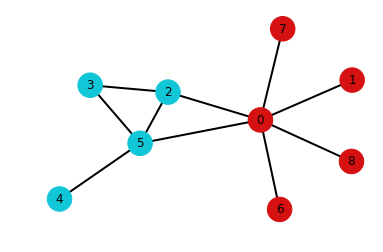

In [3]:
G = nx.Graph([(0,1),(0,2),(0,5),(0,6),(0,7),(0,8),(2,3),(2,5),(4,5),(3,5)]) # a simple graph G

# partition G into 2 groups (z as a dictionary)
z = {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0}

drawGz(G,z)

| $\pmb{e_{rs}}$  | Red (5)       | Blue (4) |
| --------------- | ------------- | -------- |
| **Red (5)**     | 4             | 2        |
| **Blue (4)**    | ---           | 4        | 

<br>

| $\pmb{\omega_{rs}}$   | Red (5)       | Blue (4) | $\pmb{\kappa_{r}}$ |
| --------------- | ------------- | -------- | ------------ |
| **Red (5)**     | 8             | 2        | 10           |
| **Blue (4)**    | 2             | 8        | 10           |

### Problem 1-B (10 pts) : Warm up, by code

* Now write a function `tabulate_ek()` that takes as input a simple graph $G$ and partition $z$, and returns the auxiliary data structures $e_{rs}$ and $\kappa_r$ for the DC-SBM.
* Apply your function to the same network $G$ and partition $z$ in `Problem 1-A` to verify your answer there.

Hint: An easy way to do this is a loop `for e in list(G.edges())` in which you increment the appropriate element of $e_{rs}$, depending on the values $z_{e[0]}$ and $z_{e[1]}$. The values of $\kappa_r$ can then be derived from $e_{rs}$. Note however, that when $G$ is a simple graph, `list(G.edges())` returns a set of *undirected* edges $\{(u,v)\}$ such that $u<v$. This means that correctly calculating $e_{rs}$ requires that you account for both $(u,v)$ and $(v,u)$ for each edge $(u,v)$ in that list.

In [22]:
def tabulate_ek(G,z,c):
    # This function tabulates the e_rs and kappa_r auxiliary data structures for the DC-SBM
    #
    # input  : G is simple graph with n nodes
    #        : z is a dictionary of group labels for G's nodes, into c groups
    #        : c is scalar, number of possible groups
    # output : ers, kpr
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted
    
    ers = np.zeros([c,c]) # count of stubs from group r to group s
    kpr = np.zeros([c,1]) # total degree of group r

    ##### do not modify above here #####
    
    ### YOUR CODE
    for i,j in G.edges():
        if (z[i] == z[j]):
            ers[z[i]][z[j]] += 1
            kpr[z[i]] += 2
        else:
            ers[z[i]][z[j]] += 1
            ers[z[j]][z[i]] += 1
            kpr[z[i]] += 1
            kpr[z[j]] += 1
        
    ##### do not modify below here #####

    return ers,kpr

In [26]:
# Your code here
e_rs,k_pr = tabulate_ek(G,z,2)
print(e_rs,'\n\n',k_pr)

[[4. 2.]
 [2. 4.]] 

 [[10.]
 [10.]]


### Problem 1-C (5 pts) : A random partition

Now write the following a function to initialize the search:
* `random_z(n,c)`: given the number of nodes `n` and groups `c`, return a dict `z` for a random partition, i.e., where `z[i] = Uniform(0,c-1)`

* Then, run the code in the second code-box below to generate a random partition on the little graph from `Problem 1-A`, calculate the mixing matrix using your `tabulate_ek()` function, and then draw the corresponding graph using `drawGz()`.

In [47]:
def random_z(n,c):
    # input  : number of nodes n, and number of groups c
    # output : returns a random partition in a dictionary z, where z_i = Uniform(0,c-1)

    import random as rnd
    rnd.seed()
    
    z = dict()

    ##### do not modify above here #####

    ### YOUR CODE
    for i in range(n):
        z[i] = int(np.round(rnd.uniform(0,c-1)))

    ##### do not modify below here #####

    return z

{0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 0, 7: 1, 8: 1}
kappa_r = 
[[11.]
 [ 9.]]
e_rs = 
[[3. 5.]
 [5. 2.]]


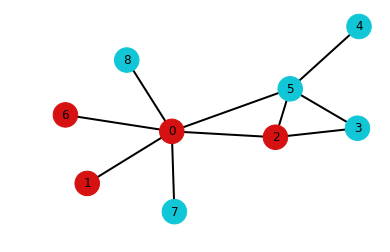

In [54]:
##### do not modify below here #####
##    run this code once you've written the random_z() function

n = G.order()
c = 2
z = random_z(n,c)
print(z)
ers,kpr = tabulate_ek(G,z,c)
print(f'kappa_r = ')
print(kpr)
print(f'e_rs = ')
print(ers)

drawGz(G,z)

##### do not modify above here #####

***
## Problem 2 : Community detection by locally greedy heuristic (75 pts total)

In this problem, you will implement and apply the `locally greedy heuristic` described in Lecture 6. To make it a little easier, the functions `dcsbm_LogL()` and `plotLL()` are provided. These (1) calculate the DC-SBM log-likelihood (when given the auxiliary data structures $e_{rs}$ and $\kappa_r$), and (2) plot the final log-likelihood trajectory of your algorithm.

- In `Problem 2-A` you'll write the core logic of the algorithm
- In `Problem 2-B` you'll wrap the core logic in a loop to complete a single phase
- In `Problem 2-C` you'll wrap your single-phase code in a loop to run the full search
- In `Problems 2-D,E` you'll apply it to some real-world networks

In [55]:
def dcsbm_LogL(ers,kpr):
    # DO NOT MODIFY THIS FUNCTION
    # This function calculates the log-likelihood of the degree-corrected stochastic block model (DC-SBM)
    # See Eq. (9) in Lecture 6.
    #
    # input  : ers is a c x c np.array of stub counts
    #        : kpr is a c x 1 np.array of stub counts 
    # output : the dcsbm log-likelihood
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    c = ers.shape[1]  # number of groups
    
    logL = 0
    for r in range(c):
        for s in range(c):
            if ers[r,s] < 1 or kpr[r] < 1 or kpr[s] < 1:
                temp = 0 # define 0^0 = 1
            else:
                temp = ers[r,s]*np.log( ers[r,s] / (kpr[r]*kpr[s]) )
            logL = logL + temp
    
    return logL
    # DO NOT MODIFY THIS FUNCTION


In [56]:
def plotLL(LL,pc,n):
    # DO NOT MODIFY THIS FUNCTION
    # This function makes a nice plot of the log-likelihood trajectory
    #
    # input  : LL is list of log-likelihood values of length (n+1)*(pc+1)
    #        : n, number of nodes
    #        : pc, number of phases in LL
    # output : none
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    tc  = len(LL)               # number of partitions considered in the LL trajectory

    fig = plt.figure()
    ax1 = fig.add_subplot(111) # put multiple 
    
    plt.plot(range(tc), LL, 'b.-', alpha=0.5)  # plot the log-likelihood trajectory
    for i in range(pc):                        # add vertical bars to demarcate phases, add black squares for phase-maxima
        plt.plot([(i)*(n+1),(i)*(n+1)],[min(LL),max(LL)], 'k--', alpha=0.5) # vertical bar
        LLp = LL[(i)*(n+1):(i+1)*(n+1)]
        b = LLp.index(max(LLp))
        plt.plot([(i)*(n+1)+b],[max(LLp)], 'ks', alpha=0.5)

    plt.ylabel('log-likelihood, DC-SBM')
    plt.xlabel('number of partitions considered')
    plt.show()

### Problem 2-A (15 pts) : Making a move

In this problem, you'll write the core logic of the locally greedy heuristic.

Recall that at each step in a _phase_ the algorithm considers *all possible* group-changes across all unfrozen nodes, of which there are $(n-t)(c-1)$ such single-node moves. Of these possible moves, it selects the one that is the greedy choice, "freezes" the node it moved, and repeats until all nodes have been frozen. When $n=t$, all nodes are frozen, and the phase is over. At this point, we look back over all $n+1$ partitions considered during this phase, and if the initial partition $z_0$ was the best, we halt and return $z_0$. Otherwise, we initialize a new phase with the best partition in the phase $z_*$ and unfreeze all the nodes.

* Write the `makeAMove()` function below, which implements the core logic of the algorithm:
  * given a graph $G$, a current partition $z_t$, a number of groups $c$, and a "mask" vector $f$ (if $f_i=1$, then $i$ is "frozen")
  * loop over the unfrozen nodes to compute the log-likelihood of each of the $c-1$ possible single-node moves for each of those nodes
  * in the process, keep track of the best log-likelihood its seen and the corresponding "best move", i.e., the node $i$ and new group $r$, that when applied to $z$ would generate that best log-likelihood.
* Include in your code the line `print(f'v[{i}] g[{int(s)}] --> g[{r}] : {thisL}')` so that for each node move considered, the function reports the node, its current group, its new group, and corresponding log-likelihood.
* Then apply `makeAMove()` to the simple graph $G$ in `Problem 1-A`, with $c=3$, a partition from `random_z()`, and $f_i=0$ for all $i$ except $f_2=1$, by running the code in the second code box below.

Hint: don't forget to put $i$ back in group $s$ after you've evaluated each of the $c-1$ alternatives.

In [58]:
def makeAMove(G,z,c,f):
    # For each non 'frozen' node in the current partition, this function tries all (c-1) possible group moves for it
    # It returns the combination of [node i and new group r] that produces the best log-likelihood over the non-frozen set
    # input  : G, a graph
    #        : z, a partition of G's nodes
    #        : c, the number of groups
    #        : f, a binary labeling of frozen nodes
    # output : bestL, the best log-likelihood found
    #        : bestMove, [i,r] the node i and new group r to achieve bestL
    
    bestL = -np.inf            # the best log-likelihood over all considered moves
    for i in G.nodes():        # loop over all nodes i
        if f[i] == 0:          # if i is not frozen
            s = int(z[i])      #  get current label of i
            for r in range(c): #  then loop over all groups r
                #print(f'v[{i}] s = {s}, r={r}, {r!=s}') # for debugging
                
                ##### do not modify above here #####

                ## YOUR CODE
                z[i] = r
                ers,kpr = tabulate_ek(G,z,c)
                cur_logL = dcsbm_LogL(ers,kpr)
                if (cur_logL > bestL):
                    bestL = cur_logL
                    bestMove = [i,r]
                
            z[i] = s
                    
                ##### do not modify below here #####    
                
    return bestL,bestMove

choiceL    = [-44.70121763]
choiceMove = node 0 --> group 1


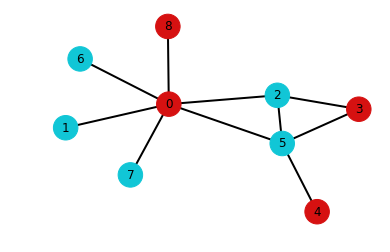

In [59]:
##### do not modify below here #####
##    run this code once you've written the makeAMove() function

n = G.order()
c = 3
z = random_z(n,c)              # initial random partition
f = dict.fromkeys(range(n), 0) # initially, all nodes unfrozen
f[2] = 1                       # but freeze node 2
choiceL,choiceMove = makeAMove(G,z,c,f)

print(f'choiceL    = {choiceL}\nchoiceMove = node {choiceMove[0]} --> group {choiceMove[1]}')
drawGz(G,z)

##### do not modify above here #####

### Problem 2-B (15 pts) : Make all the moves

* Using your results from `Problem 2-A`, write the `run_OnePhase(G,z0,c)` function below, which performs a single phase of the algorithm, starting at the input partition `z0`, and evaluates the algorithm's convergence criteria.
  * It takes as input the graph `G`, the initial partition `z0`, and the number of groups `c`.
  * It outputs 4 values: `zstar` and `Lstar`, the best partition of the phase and its LogL, a list `LL` of n+1 values LogL one for each partition in the phase (purely so that we can call `plotLL()` with it), and `halt` a binary flag that reports the convergence criteria, i.e., whether `zstar==z0` (or equivalently `tstar==0`, meaning, no better partition was found in this phase).
  * Remember that when the phase begins, `f` is all zeros (all nodes un-frozen), and we 'freeze' whichever node we end up moving as a result of calling `makeAMove()`.
* Then apply `run_OnePhase()` to the simple graph $G$ in `Problem 1-A`, with $c=3$, a partition from `random_z()`, by running the code in the second code box below.

Hint: if you track the best partition `zstar` in the natural way, you will want to use the `copy.deepcopy()` function to 'save off' a copy of `zt`.

In [ ]:
def run_OnePhase(G,z0,c):
    # Runs one phase, initialized from partition z0
    # Returns the best partition found in the phase and the list of LogL values for all the phase's partitions
    # input  : G, a graph
    #        : z0, initial partition of G's nodes
    #        : c, the number of groups
    # output : zstar, the best partition of the phase
    #        : Lstar, the LogL of zstar
    #        : LL, the inorder list of LogL values for the n+1 partitions of this phase
    #        : halt, 1 if zstar=z0 (no better partition found)

    import copy      # for copy.deepcopy() function
    n    = G.order() # n, number of nodes
    LL   = []        # stores log-likelihoods over the entire algorithm (via .append)
    halt = 0         # flag: =0 if Lstar > L0 at the end of the phase; =1 if Lstar <= L0

    # initialize the phase
    ers,kpr = tabulate_ek(G,z0,c)      # ers, kpr, initial DC-SBM parameters
    L0      = dcsbm_LogL(ers,kpr)      # store initial DC-SBM log-likelihood
    LL.append(L0)                      # track log-likelihood

    f     = dict.fromkeys(range(n), 0) # initially, all nodes unfrozen (tricky python)
    t     = 0                          # number of frozen nodes in this phase
    Lstar = L0                         # initially, z0 has the best LogL
    zstar = copy.deepcopy(z0)          # and z0 is the best partition
    tstar = t                          # tstar = 0

    # loop over all the nodes in G, making greedy move for each
    zt = copy.deepcopy(z0)             # start the loop at z0
    for j in range(n):
        #print(f'step {j}') # for debugging

        ##### do not modify above here #####

        
        ### YOUR CODE


        ##### do not modify below here #####

    return zstar,Lstar,LL,halt

In [ ]:
##### do not modify below here #####
##    run this code once you've written the run_OnePhase() function

c  = 3                   # c, number of groups
z0 = random_z(n,c)       # z0, initial partition
ers,kpr = tabulate_ek(G,z0,c)      # ers, kpr, initial DC-SBM parameters
L0      = dcsbm_LogL(ers,kpr)      # store initial DC-SBM log-likelihood

print(f'phase[0] initial z, logL = {L0}')
drawGz(G,z0)

zstar,Lstar,LL,halt = run_OnePhase(G,z0,c)

print(f'phase[0] best z, logL = {Lstar}')
drawGz(G,zstar)
plotLL(LL,0,G.order())

##### do not modify above here #####

### Problem 2-C (30 pts) : The full heuristic

* Now, using your results from `Problem 2-B`, write the `fit_DCSBM(G,c,T)` function below, which runs the full locally gready heuristic.
  * It takes as input a graph `G`, a number of groups `c`, and the maximum of phases allowed `T`.
  * It outputs 4 values: `zstar` and `Lstar`, the best partition found across all phases and its LogL, a list `LL` of all LogL values across all phases (purely so that we can call `plotLL()` with it), and `pc` the number of phases it used.
* Then apply `fit_DCSBM()` to the simple graph $G$ in `Problem 1-A`, with $c=3$ and $T=30$ phases at most, by running the code in the second code box below. This code will display the log-likelihood trajectory over the algorithm's run at the end, and apply your `tabulate_ek()` function to compute and display the mixing matrix.
* Below the code box, discuss what you see about how the algorithm performs, and what stylized structure the algorithm finds for the mixing matrix (you may want to review Lecture 5 for this).

Hint: How good a partition can you get? I got a log-likelihood of $-48.14$ or so.

In [ ]:
def fit_DCSBM(G,c,T):
    # Runs the full locally greedy heuristic, with c groups
    # Returns the best partition found, its LogL, and the list of LogL values for all partitions considered
    # input  : G, a graph
    #        : c, the number of groups
    #        : T, the number maximum number of phases allowed
    # output : zstar, the best partition of the phase
    #        : Lstar, the LogL of zstar
    #        : LL, the inorder list of all LogL values considered
    #        : pc, the number of phases in LL

    import copy # for copy.deepcopy()
    
    # 1.0 locally greedy heuristic setup
    n  = G.order() # n, number of nodes
    LL   = []      # log-likelihoods over the entire algorithm (concat via .extend)
    halt = 0       # convergence flag

    # 2.0 generate initial partition, calculate ers,kpr, and store the loglikelihood in Lt
    zt      = random_z(n,c)       # z0, initial partition
    ers,kpr = tabulate_ek(G,zt,c) # ers, kpr, initial DC-SBM parameters
    Lt      = dcsbm_LogL(ers,kpr) # store initial DC-SBM log-likelihood

    # 3.0 the main loop
    pc = 0  # counter for number of phases completed
    while not halt:
        # 3.1 visualization of this phase's initial partition
        print(f'phase[{pc}] z[0], logL = {Lt}')
        drawGz(G,zt)

        ##### do not modify above here #####

        
        ### YOUR CODE


        ##### do not modify below here #####
    
    print(f' --> WE HAVE CONVERGENCE <-- ') # a friendly alert
    return zstar,Lstar,LL,pc

In [ ]:
##### do not modify below here #####
##    run this code once you've written the fit_DCSBM() function

c    = 3       # c, number of groups
T    = 30      # maximum number of phases; HALT if pc >= T

zstar,Lstar,LL,pc = fit_DCSBM(G,c,T)

# visualize final partition, log-likelihood trajectory, and mixing matrix
print(f'phase[{pc}] z0, logL = {Lstar}')
drawGz(G,zstar)
plotLL(LL,pc,G.order())

ers,kpr = tabulate_ek(G,zstar,c)
print(f'kappa_r = ')
print(kpr)
print(f'e_rs = ')
print(ers)

##### do not modify above here #####

Your discussion here

### Problem 2-D (10 pts) : coarse-graining some real data

* Use the provided code below to load the `karate.gml` social network file that was bundled with `PS1`
* Write a loop that will repeatedly apply your locally greedy heuristic from `Problem 2-C` to this network, keeping track of the _best_ output over repetitions. (Although the algorithm itself is deterministic, it begins at a random initial partition, and so re-running the algorithm many times allows us to sample different local optima, looking for a good one.)
* Tinker with the number of repetitions needed to obtain the *optimal* $c=2$ group partition described in Lecture 6.
* Comment briefly on how well your algorithm worked at this task, how many runs it took (a lot? a little? more than you expected? fewer?)
* Bask in the glory of having implemented and applied this amazing algorithm to reproduce the results of Karrer and Newman (2011).

Hint: because you'll apply this loop again in `Problem 2-E`, you might find it convenient to put the loop inside a function, e.g., `fit_DCSBM_reps(G,c,T,reps)`, where `reps` is the number of repetitions of applying `fig_DCSBM()`.

In [ ]:
# YOUR CODE HERE

Your discussion here

### Problem 2-E (10 pts extra credit) : coarse-graining some real biological data

* Try out your DC-SBM algorithm on a few of the biological networks we've used in previous problem sets, to find the best $c=2$ group partition.
* For each, once the algorithm has halted,
  * make a visualization using `drawGz()`,
  * tabulate and inspect $e_{rs}$ and $\kappa_r$, and
  * describe in the markdown box below what you see in terms of stylized community structure patterns (none, assortative, disassortative, or core-periphery; see Lecture 5).

For reference, here are the best $c=2$ group log-likelihoods I found for some of the networks.
* *5pts extra credit* if you can find (and document) any partitions that are better.

network | log-likelihood
:--- | ---:
yeast_spliceosome | $-3488.78$
HVR_5 | $-45925.77$
HVR_1 | $-45204.71$
p.pacificus_neural | $-1544.54$
metabolism_afulgidus | $-66822.05$
grass_web | $-1115.50$

Warning: the algorithm does not scale very well, so be careful with networks $n>100$.

In [ ]:
# Your code here

Your discussion here

***
***

## Problem 3 : Reading the literature (*10 pts extra credit*)

Choose a paper from the [Supplemental Reading list on the external course webpage](http://tuvalu.santafe.edu/~aaronc/courses/3352/). Read the paper (the whole paper, not just the abstract). Think about what it says. Then, write 1-3 sentences for each of the following questions in a way that clearly summarizes the work, and its context.
* What paper did you choose?
* What was the research question?
* What was the approach the authors took to answer that question?
* What did they do well?
* What could they have done better?
* What extensions can you envision?


Do not copy any text from the paper itself; write your own summary, in your own words in Markdown in the corresponding box below. Be sure to answer each of the five questions. The amount of extra credit will depend on the accuracy and thoughtfulness of your answers.

Hint: This is a good way to generate some ideas for your class project (your proposal for that is due on **February 27th**. Also, even if you don't understand everything in the paper, that's okay. Do your best to summarize what you did understand.

* *What paper did you choose?*<br/>
Your answer here
<br/>


* *What was the research question?*<br/>
Your answer here
<br/>

* *What was the approach the authors took to answer that question?*<br/>
Your answer here
<br/>

* *What did they do well?*<br/>
Your answer here
<br/>

* *What could they have done better?*<br/>
Your answer here
<br/>

* *What extensions can you envision?*<br/>
Your answer here

***
***

## Problem 4 : Networkx tutorial (*10pts extra credit*)

The learning curve for `networkx` can be non-trivial, even with the warm-up problems of `Problem Set 1` and `Problem Set 2`. Imagine if you had the *most useful* `networkx` tutorial to help you sift through the documentation and various built-in functions, when you were first learning, and then *write that tutorial*. This tutorial would need to not *give away* any of the answers on the problem sets. Instead, it would provide useful explanations and code examples for basic tasks and functions within `networkx`. I leave it up to you to decide exactly what that means, but list some suggestions below. Remember to imagine the *most useful* tutorial you could have had.

For this question, write a small tutorial that could be made available as a _standalone Jupyter notebook_ to future students of `CSCI 3352 Biological Networks` that:
* shows how to manually build and visualize graphs with different properties
* explains and shows how to use many of the basic built-in functions
* shows how to import a `GML` file
* explains how to use markdown (with pointers to good external references)
* explains how to typeset math using $\LaTeX$ (with pointers to good external references)